In [205]:
from sqlalchemy import URL, create_engine, text as sql_text
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon
from shapely.geometry.polygon import orient
import os
import json
from pathlib import Path
from ladybug_geometry_polyskel import polyskel


import warnings
warnings.filterwarnings('ignore')

In [3]:
credentials = Path('../config/db_credentials.json')
with open(credentials, 'r') as f:
    credentials = json.load(f)

user     = credentials['user']
password = credentials['password']
host     = credentials['host']
port     = credentials['port']
database = credentials['database']

In [4]:
# create a SQLAlchemy engine object
url_object = URL.create(
    "postgresql",
    username=user,
    password=password,
    host=host,
    port=port,
    database=database
)

engine = create_engine(url_object)

In [5]:
query = """SELECT * FROM thuc_1002_annagnps_reach_ids ORDER BY dn LIMIT 37"""

raw_reaches = gpd.read_postgis(sql=sql_text(query), con=engine.connect(), geom_col='geom')

In [8]:
raw_reaches = raw_reaches.dissolve(by='dn', as_index=False)

In [9]:
def default_ax(size=8):
    fig, ax = plt.subplots()
    fig.set_size_inches(size, size)
    ax.axison = False
    ax.set_aspect('equal')
    return ax

In [206]:
def get_skeleton_network(df, reach_id):
    reach = df[df['dn']==reach_id]
    rpoly = reach.geometry.iloc[0]
    rpoly = orient(rpoly, sign=1)
    rbound = rpoly.exterior.coords
    skeleton = polyskel.skeleton_as_subtree_list(list(rbound), [])
    sg = nx.Graph()
    for edge in skeleton:
        source = edge.source
        for sink in edge.sinks:
            sg.add_edge(source, sink)
    return sg

def get_skeleton_from_poly(poly):
    bound = poly.exterior.coords
    skeleton = polyskel.skeleton_as_subtree_list(list(bound), [])
    sg = nx.Graph()
    for edge in skeleton:
        source = edge.source
        for sink in edge.sinks:
            sg.add_edge(source, sink)
    return sg

def nodes_pos_dict(G):
    pos = {}
    for node in G.nodes():
        pos[node] = (node.x, node.y)
    return pos

In [266]:
reaches_buffer = raw_reaches.copy(deep=True)
reaches_buffer.geometry = reaches_buffer.buffer(0.01).simplify(10)
# reaches_buffer.geometry = reaches_buffer.buffer(1).simplify(30)

In [276]:
reach_id = 4
reach = get_skeleton_network(reaches_buffer, reach_id)
pos = nodes_pos_dict(reach)

leaves = set()
for segment, degree in reach.degree():
    if degree < 2:
        leaves.add(segment)

reach.remove_nodes_from(leaves)

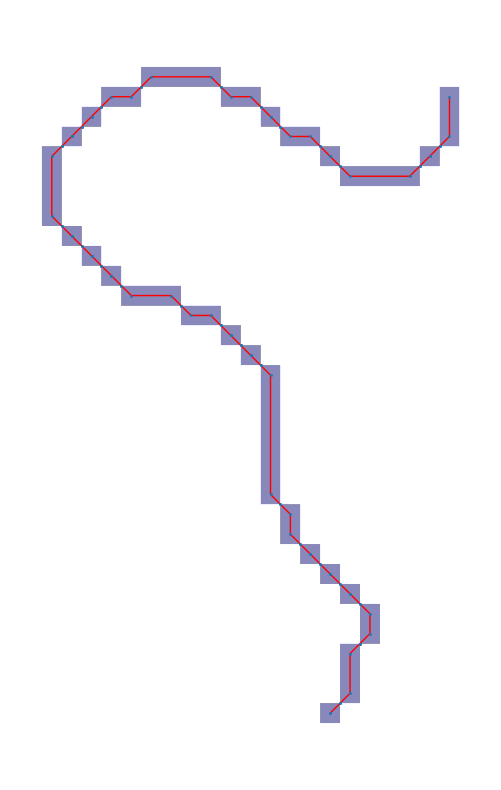

In [277]:
ax = default_ax(size=10)
raw_reaches[raw_reaches['dn'] == reach_id].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
reaches_buffer[reaches_buffer['dn']==reach_id].plot(ax=ax, linewidth=0.3, alpha=0.2, color='blue')
nx.draw(reach, pos, node_size = 1, ax=ax, edge_color='r')
plt.show()

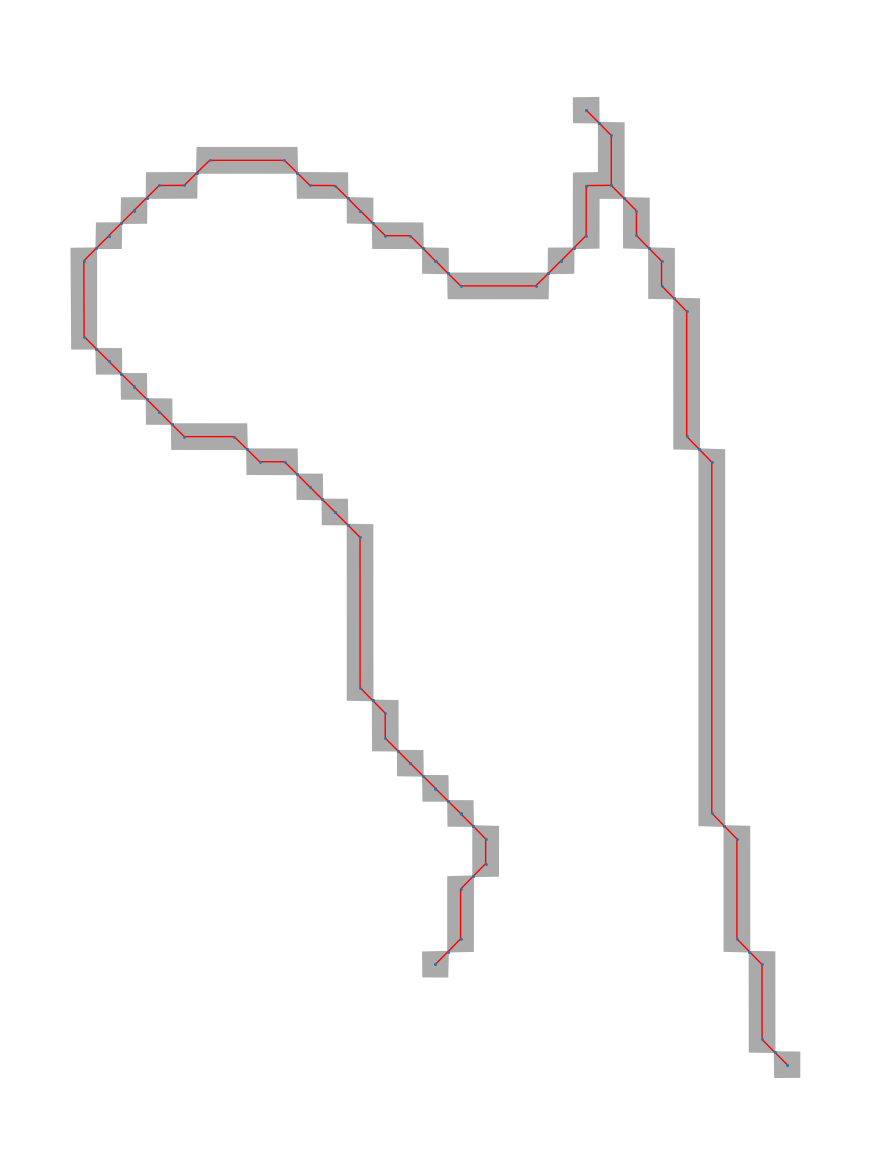

In [279]:
# poly = Polygon([(0,0), (1,0), (1,2), (0,2)])
# x = [446062.03539216705, 446032.32828538585, 446093.80840262043, 446154.01617744745, 446213.23048248905, 446152.0402074404, 446122.03539216705, 446062.03539216705]
# y = [4278363.15986837, 4278394.866975151, 4278364.794261654, 4278244.354958692, 4277463.179083089, 4277614.0618512295, 4278243.15986837, 4278363.15986837]
# poly = Polygon([(x,y) for x, y in zip(x,y)])

poly = raw_reaches.unary_union.buffer(1).simplify(5)


poly = orient(poly, sign=1)

gdf_poly = gpd.GeoDataFrame(geometry=[poly])

G = get_skeleton_from_poly(poly)

leaves = set()
for node, degree in G.degree():
    if degree < 2:
        leaves.add(node)

G.remove_nodes_from(leaves)
posG = nodes_pos_dict(G)

ax = default_ax(size=15)
gdf_poly.plot(ax=ax, linewidth=0.3, color='#aaaaaa')
nx.draw(G, posG, node_size = 1, ax=ax, edge_color='r')
plt.show()